# **Prediksi Polusi Udara**

### **Import Library**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM

### **Load Dataset**

In [5]:
df = pd.read_csv('final.csv')

df.head()

,created_at,entry_id,field1,field2,latitude,longitude,elevation,status
0,2024-12-11T12:41:13+00:00,1,402.81,0.64,NaN,NaN,NaN,NaN
1,2024-12-11T12:41:29+00:00,2,402.69,0.65,NaN,NaN,NaN,NaN
2,2024-12-11T12:41:45+00:00,3,402.76,0.64,NaN,NaN,NaN,NaN
3,2024-12-11T12:42:01+00:00,4,402.66,0.65,NaN,NaN,NaN,NaN
4,2024-12-11T12:42:17+00:00,5,402.66,0.65,NaN,NaN,NaN,NaN


In [6]:
df.drop(columns=['latitude', 'longitude', 'elevation', 'status'], inplace=True)

df.head()

,created_at,entry_id,field1,field2
0,2024-12-11T12:41:13+00:00,1,402.81,0.64
1,2024-12-11T12:41:29+00:00,2,402.69,0.65
2,2024-12-11T12:41:45+00:00,3,402.76,0.64
3,2024-12-11T12:42:01+00:00,4,402.66,0.65
4,2024-12-11T12:42:17+00:00,5,402.66,0.65


In [7]:
df.rename(columns={'field1': 'CO2', 'field2': 'CO'}, inplace=True)

df.tail(3)

,created_at,entry_id,CO2,CO
160782,2025-01-12T01:09:41+00:00,160783,424.71,0.80
160783,2025-01-12T01:09:57+00:00,160784,425.55,0.80
160784,2025-01-12T01:10:13+00:00,160785,431.22,0.81


In [8]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160785 entries, 0 to 160784
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   created_at  160785 non-null  datetime64[ns, UTC]
 1   entry_id    160785 non-null  int64              
 2   CO2         160785 non-null  float64            
 3   CO          160785 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1)
memory usage: 4.9 MB


### **Exploratory Data Analysis**

**Resampling data menjadi permenit**

In [10]:
# Set kolom 'created_at' sebagai index
df = df.set_index('created_at')

In [11]:
df_rounded = df.round(2)

In [12]:
# Resample per menit, ambil mean (rata-rata) untuk setiap menit
df_per_2menit = df_rounded.resample('2min').mean()
df_per_2menit = df_per_2menit.round(2)
df_per_2menit

,entry_id,CO2,CO
created_at,,,
2024-12-11 12:40:00+00:00,2.0,402.75,0.64
2024-12-11 12:42:00+00:00,7.5,402.70,0.65
2024-12-11 12:44:00+00:00,14.5,402.73,0.66
2024-12-11 12:46:00+00:00,NaN,NaN,NaN
2024-12-11 12:48:00+00:00,NaN,NaN,NaN
...,...,...,...
2025-01-12 01:02:00+00:00,160758.5,430.33,0.80
2025-01-12 01:04:00+00:00,160765.5,428.32,0.80
2025-01-12 01:06:00+00:00,160773.0,430.19,0.80


In [13]:
df_per_2menit.describe()

,entry_id,CO2,CO
count,22402.000000,22402.000000,22402.000000
mean,81384.090729,410.319198,1.247007
std,46418.413066,11.854514,0.470648
min,2.000000,400.070000,0.190000
25%,41230.375000,403.090000,0.700000
50%,82013.500000,406.690000,1.350000
75%,121671.125000,413.660000,1.630000
max,160785.000000,552.590000,3.890000


<Axes: xlabel='created_at'>

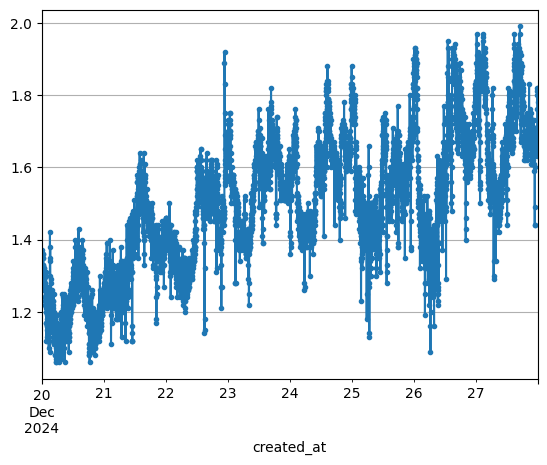

In [36]:
df_per_2menit['CO']['2024-12-20':'2024-12-27'].plot(grid=True, marker='.')

<Axes: xlabel='created_at'>

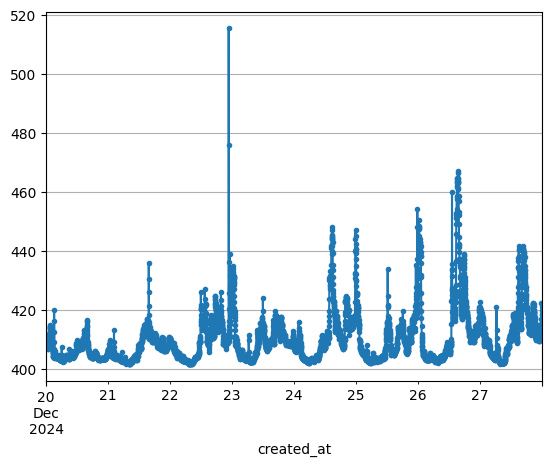

In [37]:
df_per_2menit['CO2']['2024-12-20':'2024-12-27'].plot(grid=True, marker='.')

<Axes: xlabel='created_at'>

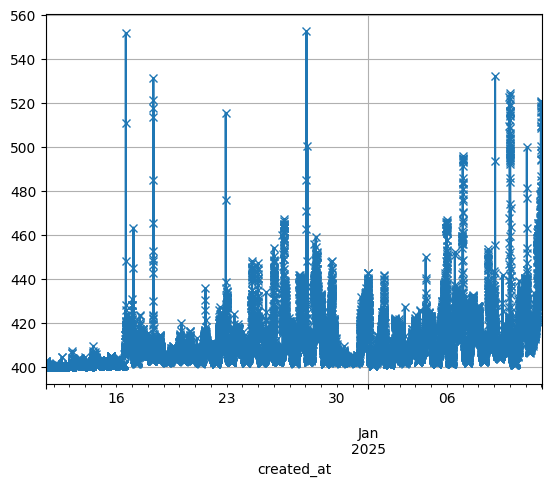

In [18]:
df_per_2menit['CO2'].plot(grid=True, marker='x')

<Axes: xlabel='created_at'>

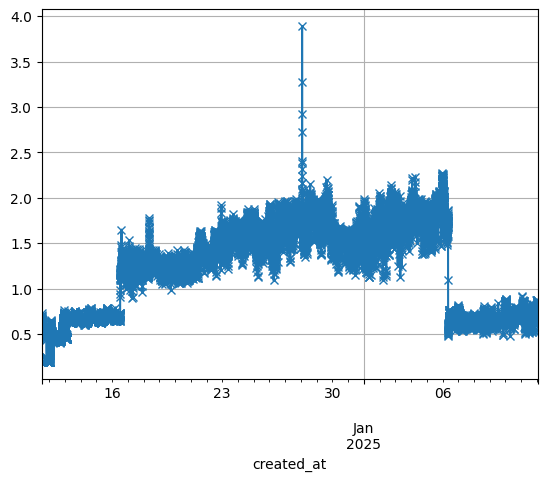

In [28]:
df_per_2menit['CO'].plot(grid=True, marker='x')

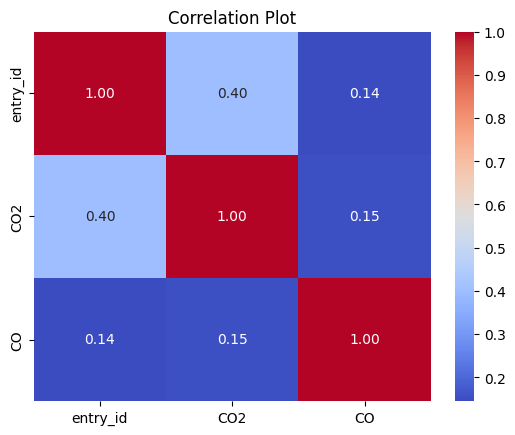

In [20]:
correlation = df_per_2menit[['entry_id','CO2', 'CO']].corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Plot')
plt.show()

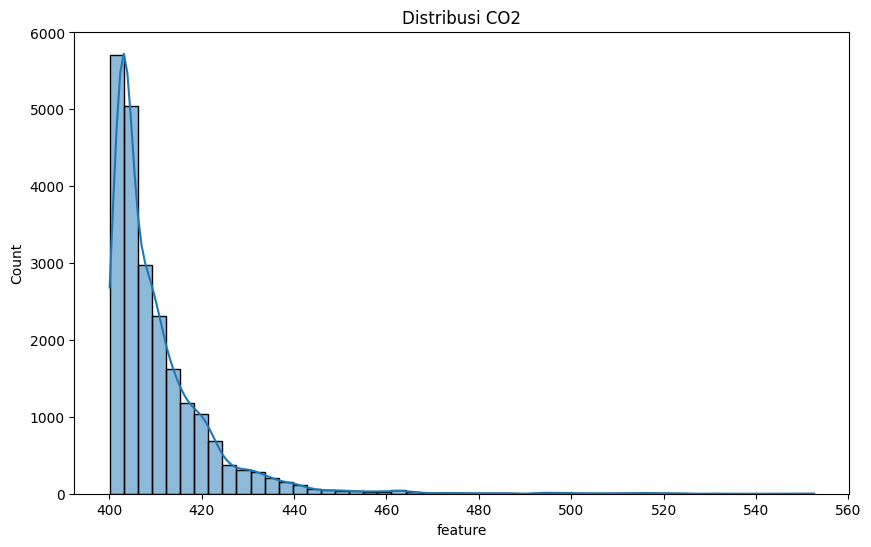

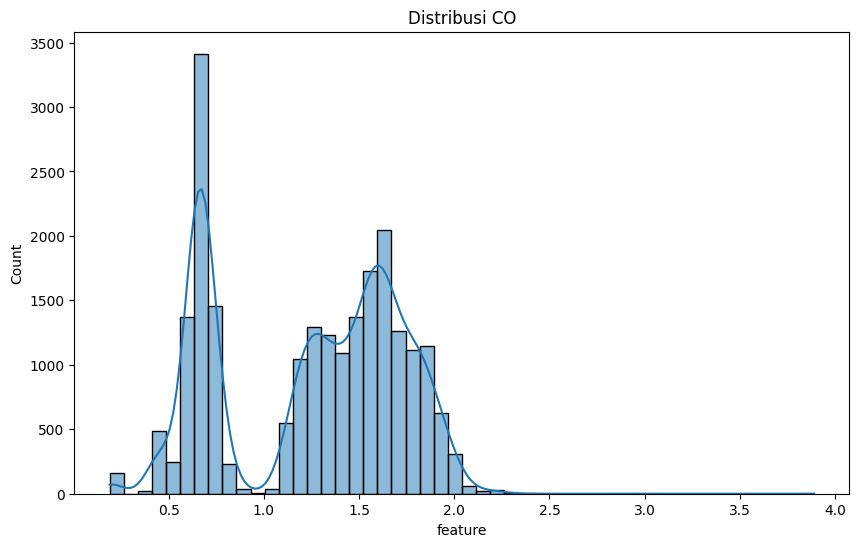

In [21]:
numeric_feature = ["CO2", "CO"]

for feature in numeric_feature:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_per_2menit[feature], kde=True, bins=50)
    plt.title(f"Distribusi {feature}")
    plt.xlabel("feature")

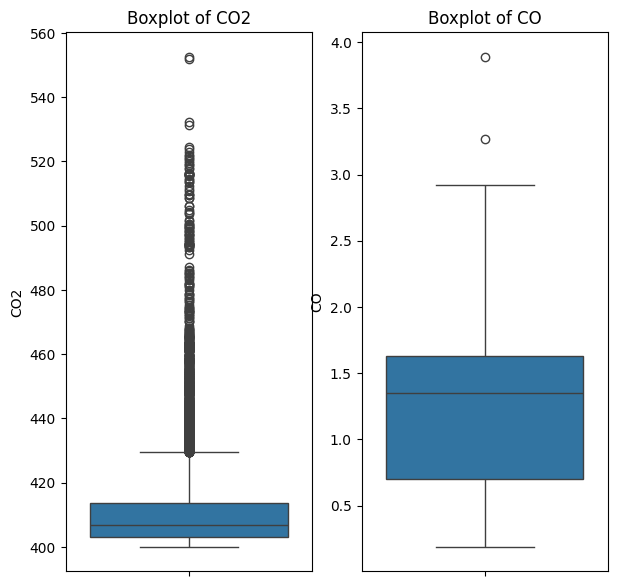

In [22]:
plt.figure(figsize=(7, 7))

plt.subplot2grid((2, 2), (0, 0), rowspan=2, colspan=1)
sns.boxplot( df_per_2menit['CO2'], label='CO2')
plt.title("Boxplot of CO2")


plt.subplot2grid((2, 2), (0, 1), rowspan=2, colspan=1)
sns.boxplot(df_per_2menit['CO'], label='CO')
plt.title("Boxplot of CO")
plt.show()

In [23]:
df_per_2menit.duplicated().sum()

293

In [24]:
df_per_2menit = df_per_2menit.interpolate(method='time')

In [25]:
df_per_2menit.isnull().sum()

entry_id    0
CO2         0
CO          0
dtype: int64

In [26]:
# Hapus baris duplikat (hanya jika semua kolom sama persis)
df_per_2menit = df_per_2menit.drop_duplicates()

In [27]:
df_per_2menit.duplicated().sum()

0

## Pemodelan Menggunakan LSTM

In [39]:
df_per_2menit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22696 entries, 2024-12-11 12:40:00+00:00 to 2025-01-12 01:10:00+00:00
Freq: 2min
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   entry_id  22696 non-null  float64
 1   CO2       22696 non-null  float64
 2   CO        22696 non-null  float64
dtypes: float64(3)
memory usage: 1.2 MB


In [106]:
df_per_2menit.describe()

,CO2,CO
count,22696.000000,22696.000000
mean,410.209353,1.238428
std,11.820341,0.474403
min,400.070000,0.190000
25%,403.010000,0.700000
50%,406.540000,1.340000
75%,413.550000,1.630000
max,552.590000,3.890000


In [107]:
df_per_2menit.head(1)

,CO2,CO
created_at,,
2024-12-11 12:40:00+00:00,402.75,0.64


In [41]:
df_per_2menit.duplicated().sum()

0

In [72]:
df_per_2menit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22696 entries, 2024-12-11 12:40:00+00:00 to 2025-01-12 01:10:00+00:00
Freq: 2min
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   entry_id  22696 non-null  float64
 1   CO2       22696 non-null  float64
 2   CO        22696 non-null  float64
dtypes: float64(3)
memory usage: 1.2 MB


## Multivariat Multi Step Forecasting

In [73]:
df_per_2menit = df_per_2menit.drop(columns=['entry_id'])

In [75]:
# Tentukan proporsi
n = len(df_per_2menit)
train_size = int(n * 0.7)
val_size = int(n * 0.15)

# Split berdasarkan urutan waktu
train_df = df_per_2menit.iloc[:train_size]
val_df   = df_per_2menit.iloc[train_size:train_size + val_size]
test_df  = df_per_2menit.iloc[train_size + val_size:]


In [76]:
scaler = MinMaxScaler()
scaler.fit(train_df)

# 3. Transform semua data
train_scaled = scaler.transform(train_df)
valid_scaled = scaler.transform(val_df)
test_scaled  = scaler.transform(test_df)

### Melakukan window splitting

In [89]:
tf.random.set_seed(42)

# Membuat fungsi untuk split data input dan target
def split_inputs_and_targets(mulvar_series, ahead=10, target_cols=[0, 1]):
    # input semua timestamp kecuali 10 langkah ke depan
    X = mulvar_series[:, :-ahead, :]

    # output: nilai aktual untuk 10 langkah kedepan
    Y = mulvar_series[:, -ahead:, :]
    Y = tf.gather(Y, target_cols, axis=-1)  # ambil hanya fitur target (CO2 dan CO)
    
    return X, Y

In [90]:
seq_length = 30

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train_scaled,
    targets=None,
    sequence_length=seq_length + 10,
    batch_size=32,
    shuffle=True
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid_scaled,
    targets=None,
    sequence_length=seq_length + 10,
    batch_size=32,
    shuffle=True
).map(split_inputs_and_targets)

ahead_test_ds = tf.keras.utils.timeseries_dataset_from_array(
    test_scaled,
    targets=None,
    sequence_length=seq_length + 10,  # 30 input + 10 output
    batch_size=32,
    shuffle=False
).map(split_inputs_and_targets)  # target [1,2] = CO2 & CO


In [ ]:

ahead_test_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=test_scaled,
    targets=None,
    sequence_length=seq_length + 10,  # contoh: 30 + 10 = 40
    batch_size=32,
    shuffle=False
).map(split_inputs_and_targets)


In [91]:
# tf.keras.backend.clear_session()
tf.random.set_seed(42)

mulvar_multask_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(None, 2)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(10 * 2),
    tf.keras.layers.Reshape((10, 2))
])

In [92]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_squared_error', patience=10, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5", save_best_only=True, monitor="val_mean_squared_error")

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
mulvar_multask_model.compile(loss="mse", optimizer=optimizer, metrics=["MeanSquaredError"])

In [93]:
mulvar_multask_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, None, 32)          4480      
                                                                 
 lstm_10 (LSTM)              (None, None, 32)          8320      
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 20)                660       
                                                                 
 reshape_3 (Reshape)         (None, 10, 2)             0         
                                                                 
Total params: 21,780
Trainable params: 21,780
Non-trainable params: 0
_________________________________________________________________


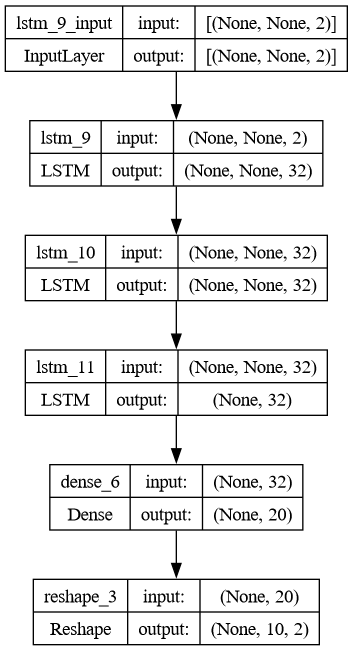

In [94]:
tf.keras.utils.plot_model(mulvar_multask_model, show_shapes=True)

In [95]:
with tf.device('/GPU:0'):
    history = mulvar_multask_model.fit(ahead_train_ds, epochs=30, validation_data=ahead_valid_ds, callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/30
496/496 [==============================] - 8s 12ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 2/30
496/496 [==============================] - 6s 11ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 3/30
496/496 [==============================] - 6s 11ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 4/30
496/496 [==============================] - 6s 11ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 5/30
496/496 [==============================] - 5s 11ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 6/30
496/496 [==============================] - 6s 11ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 7/30
496/496 [==

In [96]:
valid_loss, valid_mae = mulvar_multask_model.evaluate(ahead_valid_ds)

106/106 [==============================] - 1s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016


In [98]:
y_pred = mulvar_multask_model.predict(ahead_test_ds)  # hasil: shape (batch, 10, 2)

106/106 [==============================] - 1s 6ms/step


In [99]:
import numpy as np

y_true = np.concatenate([y.numpy() for _, y in ahead_test_ds], axis=0)


In [100]:
# Pastikan scaler_y sudah di-fit ke train_df[['field1', 'field2']]
y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 2)).reshape(y_pred.shape)
y_true_orig = scaler.inverse_transform(y_true.reshape(-1, 2)).reshape(y_true.shape)


In [101]:
y_pred_orig

array([[[403.73056   ,   0.6196709 ],
        [403.3539    ,   0.6229302 ],
        [403.2437    ,   0.6163717 ],
        ...,
        [403.96997   ,   0.616017  ],
        [403.55768   ,   0.62062025],
        [403.6268    ,   0.61160606]],

       [[403.8826    ,   0.623804  ],
        [403.49118   ,   0.6267793 ],
        [403.38812   ,   0.619938  ],
        ...,
        [404.0724    ,   0.6201925 ],
        [403.6819    ,   0.6245447 ],
        [403.7163    ,   0.61520255]],

       [[403.98856   ,   0.62701845],
        [403.60406   ,   0.6297852 ],
        [403.50314   ,   0.62270623],
        ...,
        [404.12195   ,   0.6234665 ],
        [403.77026   ,   0.62742394],
        [403.7477    ,   0.6181227 ]],

       ...,

       [[434.7605    ,   0.76406604],
        [438.44998   ,   0.8305173 ],
        [432.1389    ,   0.8131452 ],
        ...,
        [438.43478   ,   0.7331547 ],
        [440.6444    ,   0.72724694],
        [429.21353   ,   0.5471084 ]],

       [[434.04

In [ ]:
y_true_orig.shape

NameError: name 'y_true_orig' is not defined

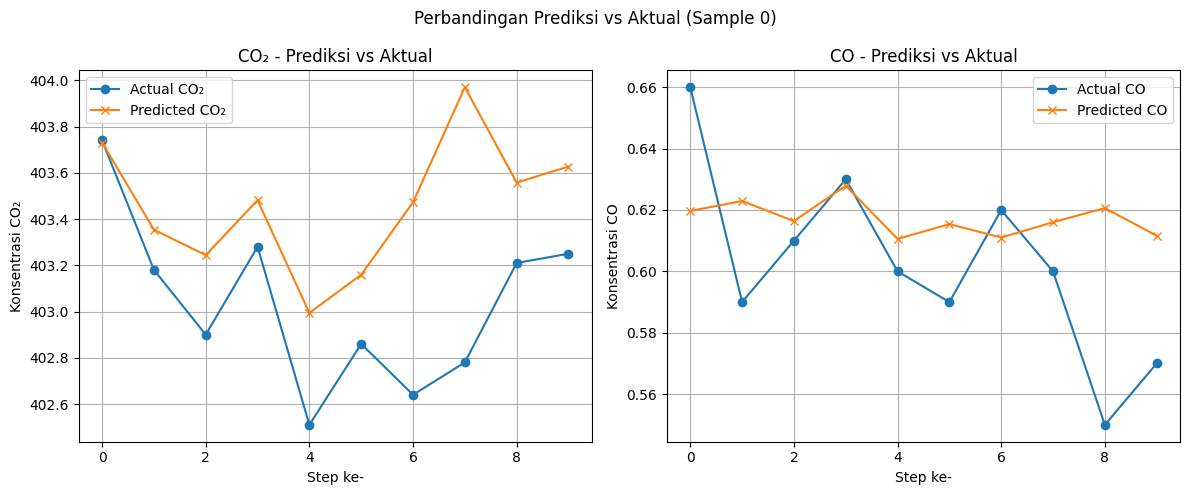

In [103]:
import matplotlib.pyplot as plt

sample_index = 0  # bisa diganti ke 1, 2, dst.

plt.figure(figsize=(12, 5))

# Plot CO₂ (index 0)
plt.subplot(1, 2, 1)
plt.plot(y_true_orig[sample_index, :, 0], label='Actual CO₂', marker='o')
plt.plot(y_pred_orig[sample_index, :, 0], label='Predicted CO₂', marker='x')
plt.title('CO₂ - Prediksi vs Aktual')
plt.xlabel('Step ke-')
plt.ylabel('Konsentrasi CO₂')
plt.legend()
plt.grid(True)

# Plot CO (index 1)
plt.subplot(1, 2, 2)
plt.plot(y_true_orig[sample_index, :, 1], label='Actual CO', marker='o')
plt.plot(y_pred_orig[sample_index, :, 1], label='Predicted CO', marker='x')
plt.title('CO - Prediksi vs Aktual')
plt.xlabel('Step ke-')
plt.ylabel('Konsentrasi CO')
plt.legend()
plt.grid(True)

plt.suptitle(f'Perbandingan Prediksi vs Aktual (Sample {sample_index})')
plt.tight_layout()
plt.show()
